In [ ]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

# data I/O
data = open('input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)

  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients

  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]


def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes


n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter

  if( n > 10000 ):
    break

data has 1010991 characters, 94 unique.
----
 8K
s”yHkO*vMfc]a4ê6TjdZchEnuèR4è(Sa)c9éyP&ææTdHp!nZE3*IWV,#aèYæ“Lh2kuE1JæoMölCOI“nB
Hp6;öhàLDUèqyz
a4Bdu…9Jpô!CLeC?éD—TP,DVât_höqC(&0BèS.xtxxREO9]&tXzE8R“b5æo0“—;ôJIRGIhf.W:và!LEjômB0x#)TösCA“l-ùI8ét8 
----
iter 0, loss: 113.582372
----
 hhEhhhN
PhhAh HhhhWCIhh.h  nhhrhh R ahhhth.hhh hahHhhhhhhhhhh hhhhhhhhh  hhay.hhIhha
ChhhhLX hOhhhhhhBEhhhR  IhhLhhhh hha hhW hhhnEhhNhhahhhh hhhhsBhhhhhRhhhhLhhLsRFhhohhh .XAhhhhXhhhhhDnhhhshhhhhhhLh 
----
iter 100, loss: 114.231603
----
 s hmr mmf meofenwwisfuomheoaso dli fseonmmisfowi f msosmTfodfhHmeofftfof wwcw hnefif,le nns ; ay offmsfmmogmifT an suf sfnsreinno iemidsonf mhmssmnm w e fflsnisusitrcfoe  semeissoof d
tomff laffnfoffe 
----
iter 200, loss: 111.693017
----
 o ucuqooen,eeonnehf bylrureeoof uco.c ocneou t.or ounu
oan hyn oc onn’ id fm nnfn uSalbhenf ba noonyiu squh i k aocu dcn w
doa
ooew n veIad no nboretinintcea tonioigoecmuv ocwceef nonuasMees tnoo cure 
----
iter 300, loss: 108.879606
--

In [ ]:
from __future__ import print_function

import numpy as np
import sys

# Make it possible to provide input file as a command-line argument; input.txt
# is still the default.
# if len(sys.argv) > 1:
#     filename = sys.argv[1]
# else:
#     filename = 'input.txt'

filename = 'input.txt'

with open(filename, 'r') as f:
    data = f.read()

# All unique characters / entities in the data set.
chars = list(set(data))
data_size = len(data)
V = vocab_size = len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))

# Each character in the vocabulary gets a unique integer index assigned, in the
# half-open interval [0:N). These indices are useful to create one-hot encoded
# vectors that represent characters in numerical computations.
char_to_ix = {ch:i for i, ch in enumerate(chars)}
ix_to_char = {i:ch for i, ch in enumerate(chars)}
print('char_to_ix', char_to_ix)
print('ix_to_char', ix_to_char)

# Hyperparameters.

# Size of hidden state vectors; applies to h and c.
H = hidden_size = 100
seq_length = 16 # number of steps to unroll the LSTM for
learning_rate = 0.1

# The input x is concatenated with state h, and the joined vector is used to
# feed into most blocks within the LSTM cell. The combined height of the column
# vector is HV.
HV = H + V

# Stop when processed this much data
MAX_DATA = 10000000

# Model parameters/weights -- these are shared among all steps. Weights
# initialized randomly; biases initialized to 0.
# Inputs are characters one-hot encoded in a vocab-sized vector.
# Dimensions: H = hidden_size, V = vocab_size, HV = hidden_size + vocab_size
Wf = np.random.randn(H, HV) * 0.01
bf = np.zeros((H, 1))
Wi = np.random.randn(H, HV) * 0.01
bi = np.zeros((H, 1))
Wcc = np.random.randn(H, HV) * 0.01
bcc = np.zeros((H, 1))
Wo = np.random.randn(H, HV) * 0.01
bo = np.zeros((H, 1))
Wy = np.random.randn(V, H) * 0.01
by = np.zeros((V, 1))


def sigmoid(z):
    """Computes sigmoid function.
    z: array of input values.
    Returns array of outputs, sigmoid(z).
    """
    # Note: this version of sigmoid tries to avoid overflows in the computation
    # of e^(-z), by using an alternative formulation when z is negative, to get
    # 0. e^z / (1+e^z) is equivalent to the definition of sigmoid, but we won't
    # get e^(-z) to overflow when z is very negative.
    # Since both the x and y arguments to np.where are evaluated by Python, we
    # may still get overflow warnings for large z elements; therefore we ignore
    # warnings during this computation.
    with np.errstate(over='ignore', invalid='ignore'):
        return np.where(z >= 0,
                        1 / (1 + np.exp(-z)),
                        np.exp(z) / (1 + np.exp(z)))


def lossFun(inputs, targets, hprev, cprev):
    """Runs forward and backward passes through the RNN.
      TODO: keep me updated!
      inputs, targets: Lists of integers. For some i, inputs[i] is the input
                       character (encoded as an index into the ix_to_char map)
                       and targets[i] is the corresponding next character in the
                       training data (similarly encoded).
      hprev: Hx1 array of initial hidden state
      cprev: Hx1 array of initial hidden state
      returns: loss, gradients on model parameters, and last hidden states
    """
    # Caches that keep values computed in the forward pass at each time step, to
    # be reused in the backward pass.
    xs, xhs, ys, ps, hs, cs, fgs, igs, ccs, ogs = (
            {}, {}, {}, {}, {}, {}, {}, {}, {}, {})

    # Initial incoming states.
    hs[-1] = np.copy(hprev)
    cs[-1] = np.copy(cprev)

    loss = 0
    # Forward pass
    for t in range(len(inputs)):
        # Input at time step t is xs[t]. Prepare a one-hot encoded vector of
        # shape (V, 1). inputs[t] is the index where the 1 goes.
        xs[t] = np.zeros((V, 1))
        xs[t][inputs[t]] = 1

        # hprev and xs[t] are column vector; stack them together into a "taller"
        # column vector - first the elements of x, then h.
        xhs[t] = np.vstack((xs[t], hs[t-1]))

        # Gates f, i and o.
        fgs[t] = sigmoid(np.dot(Wf, xhs[t]) + bf)
        igs[t] = sigmoid(np.dot(Wi, xhs[t]) + bi)
        ogs[t] = sigmoid(np.dot(Wo, xhs[t]) + bo)

        # Candidate cc.
        ccs[t] = np.tanh(np.dot(Wcc, xhs[t]) + bcc)

        # This step's h and c.
        cs[t] = fgs[t] * cs[t-1] + igs[t] * ccs[t]
        hs[t] = np.tanh(cs[t]) * ogs[t]

        # Softmax for output.
        ys[t] = np.dot(Wy, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))

        # Cross-entropy loss.
        loss += -np.log(ps[t][targets[t], 0])

    # Initialize gradients of all weights/biases to 0.
    dWf = np.zeros_like(Wf)
    dbf = np.zeros_like(bf)
    dWi = np.zeros_like(Wi)
    dbi = np.zeros_like(bi)
    dWcc = np.zeros_like(Wcc)
    dbcc = np.zeros_like(bcc)
    dWo = np.zeros_like(Wo)
    dbo = np.zeros_like(bo)
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    # Incoming gradients for h and c; for backwards loop step these represent
    # dh[t] and dc[t]; we do truncated BPTT, so assume they are 0 initially.
    dhnext = np.zeros_like(hs[0])
    dcnext = np.zeros_like(cs[0])

    # The backwards pass iterates over the input sequence backwards.
    for t in reversed(range(len(inputs))):
        # Backprop through the gradients of loss and softmax.
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1

        # Compute gradients for the Wy and by parameters.
        dWy += np.dot(dy, hs[t].T)
        dby += dy

        # Backprop through the fully-connected layer (Wy, by) to h. Also add up
        # the incoming gradient for h from the next cell.
        dh = np.dot(Wy.T, dy) + dhnext

        # Backprop through multiplication with output gate; here "dtanh" means
        # the gradient at the output of tanh.
        dctanh = ogs[t] * dh
        # Backprop through the tanh function; since cs[t] branches in two
        # directions we add dcnext too.
        dc = dctanh * (1 - np.tanh(cs[t]) ** 2) + dcnext

        # Backprop through multiplication with the tanh; here "dhogs" means
        # the gradient at the output of the sigmoid of the output gate. Then
        # backprop through the sigmoid itself (ogs[t] is the sigmoid output).
        dhogs = dh * np.tanh(cs[t])
        dho = dhogs * ogs[t] * (1 - ogs[t])

        # Compute gradients for the output gate parameters.
        dWo += np.dot(dho, xhs[t].T)
        dbo += dho

        # Backprop dho to the xh input.
        dxh_from_o = np.dot(Wo.T, dho)

        # Backprop through the forget gate: sigmoid and elementwise mul.
        dhf = cs[t-1] * dc * fgs[t] * (1 - fgs[t])
        dWf += np.dot(dhf, xhs[t].T)
        dbf += dhf
        dxh_from_f = np.dot(Wf.T, dhf)

        # Backprop through the input gate: sigmoid and elementwise mul.
        dhi = ccs[t] * dc * igs[t] * (1 - igs[t])
        dWi += np.dot(dhi, xhs[t].T)
        dbi += dhi
        dxh_from_i = np.dot(Wi.T, dhi)

        dhcc = igs[t] * dc * (1 - ccs[t] ** 2)
        dWcc += np.dot(dhcc, xhs[t].T)
        dbcc += dhcc
        dxh_from_cc = np.dot(Wcc.T, dhcc)

        # Combine all contributions to dxh, and extract the gradient for the
        # h part to propagate backwards as dhnext.
        dxh = dxh_from_o + dxh_from_f + dxh_from_i + dxh_from_cc
        dhnext = dxh[V:, :]

        # dcnext from dc and the forget gate.
        dcnext = fgs[t] * dc

    # Gradient clipping to the range [-5, 5].
    for dparam in [dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return (loss, dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby,
            hs[len(inputs)-1], cs[len(inputs)-1])


def sample(h, c, seed_ix, n):
    """Sample a sequence of integers from the model.
    Runs the LSTM in forward mode for n steps; seed_ix is the seed letter for
    the first time step, h and c are the memory state. Returns a sequence of
    letters produced by the model (indices).
    """
    x = np.zeros((V, 1))
    x[seed_ix] = 1
    ixes = []

    for t in range(n):
        # Run the forward pass only.
        xh = np.vstack((x, h))
        fg = sigmoid(np.dot(Wf, xh) + bf)
        ig = sigmoid(np.dot(Wi, xh) + bi)
        og = sigmoid(np.dot(Wo, xh) + bo)
        cc = np.tanh(np.dot(Wcc, xh) + bcc)
        c = fg * c + ig * cc
        h = np.tanh(c) * og
        y = np.dot(Wy, h) + by
        p = np.exp(y) / np.sum(np.exp(y))

        # Sample from the distribution produced by softmax.
        ix = np.random.choice(range(V), p=p.ravel())
        x = np.zeros((V, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes


def gradCheck(inputs, targets, hprev, cprev):
    global Wf, Wi, bf, bi, Wcc, bcc, Wo, bo, Wy, by
    num_checks, delta = 10, 1e-5
    (_, dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby,
     _, _) = lossFun(inputs, targets, hprev, cprev)
    for param, dparam, name in zip(
            [Wf, bf, Wi, bi, Wcc, bcc, Wo, bo, Wy, by],
            [dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby],
            ['Wf', 'bf', 'Wi', 'bi', 'Wcc', 'bcc', 'Wo', 'bo', 'Wy', 'by']):
        assert dparam.shape == param.shape
        print(name)
        for i in range(num_checks):
            ri = np.random.randint(0, param.size)
            old_val = param.flat[ri]
            param.flat[ri] = old_val + delta
            numloss0 = lossFun(inputs, targets, hprev, cprev)[0]
            param.flat[ri] = old_val - delta
            numloss1 = lossFun(inputs, targets, hprev, cprev)[0]
            param.flat[ri] = old_val # reset
            grad_analytic = dparam.flat[ri]
            grad_numerical = (numloss0 - numloss1) / (2 * delta)
            if grad_numerical + grad_analytic == 0:
                rel_error = 0
            else:
                rel_error = (abs(grad_analytic - grad_numerical) /
                             abs(grad_numerical + grad_analytic))
            print('%s, %s => %e' % (grad_numerical, grad_analytic, rel_error))


def basicGradCheck():
    inputs = [char_to_ix[ch] for ch in data[:seq_length]]
    targets = [char_to_ix[ch] for ch in data[1:seq_length+1]]
    hprev = np.random.randn(H, 1)
    cprev = np.random.randn(H, 1)
    gradCheck(inputs, targets, hprev, cprev)

# Uncomment this to run gradient checking instead of training
#basicGradCheck()
#sys.exit()

# n is the iteration counter; p is the input sequence pointer, at the beginning
# of each step it points at the sequence in the input that will be used for
# training this iteration.
n, p = 0, 0

# Memory variables for Adagrad.
mWf = np.zeros_like(Wf)
mbf = np.zeros_like(bf)
mWi = np.zeros_like(Wi)
mbi = np.zeros_like(bi)
mWcc = np.zeros_like(Wcc)
mbcc = np.zeros_like(bcc)
mWo = np.zeros_like(Wo)
mbo = np.zeros_like(bo)
mWy = np.zeros_like(Wy)
mby = np.zeros_like(by)
smooth_loss = -np.log(1.0/V) * seq_length

while p < MAX_DATA:
    # Prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0:
        # Reset RNN memory
        hprev = np.zeros((H, 1))
        cprev = np.zeros((H, 1))
        p = 0 # go from start of data

    # In each step we unroll the RNN for seq_length cells, and present it with
    # seq_length inputs and seq_length target outputs to learn.
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # Sample from the model now and then.
    if n % 1000 == 0:
        sample_ix = sample(hprev, cprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt,))

    # Forward seq_length characters through the RNN and fetch gradient.
    (loss, dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby,
     hprev, cprev) = lossFun(inputs, targets, hprev, cprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 200 == 0:
        print('iter %d (p=%d), loss %f' % (n, p, smooth_loss))

    # Perform parameter update with Adagrad.
    for param, dparam, mem in zip(
            [Wf, bf, Wi, bi, Wcc, bcc, Wo, bo, Wy, by],
            [dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby],
            [mWf, mbf, mWi, mbi, mWcc, mbcc, mWo, mbo, mWy, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8)

    p += seq_length
    n += 1

data has 1799298 characters, 105 unique.
char_to_ix {'%': 0, 'g': 1, 'F': 2, 'j': 3, 'P': 4, '?': 5, '“': 6, 'Q': 7, '…': 8, 'ä': 9, 'L': 10, ':': 11, ';': 12, '(': 13, '1': 14, '\n': 15, '—': 16, 'é': 17, '_': 18, 'J': 19, 'ö': 20, 'O': 21, 'p': 22, 'A': 23, 'u': 24, 'œ': 25, 't': 26, 'ô': 27, ']': 28, 'q': 29, '2': 30, 'H': 31, '"': 32, '$': 33, 'i': 34, '8': 35, 'x': 36, 'I': 37, 's': 38, 'è': 39, 'ù': 40, 'b': 41, 'R': 42, 'X': 43, 'T': 44, '#': 45, '’': 46, '*': 47, 'h': 48, '4': 49, 'E': 50, 'ü': 51, 'm': 52, 'v': 53, 'N': 54, '.': 55, "'": 56, 'z': 57, 'f': 58, 'S': 59, '-': 60, 'û': 61, 'o': 62, 'ò': 63, 'Y': 64, 'k': 65, '5': 66, 'y': 67, '”': 68, 'î': 69, ')': 70, ' ': 71, 'B': 72, '‘': 73, 'w': 74, 'a': 75, ',': 76, 'e': 77, '!': 78, '[': 79, 'n': 80, '/': 81, '9': 82, '7': 83, 'K': 84, 'l': 85, 'W': 86, 'D': 87, '6': 88, 'U': 89, 'c': 90, '3': 91, 'ê': 92, 'r': 93, 'â': 94, '&': 95, 'æ': 96, 'M': 97, 'd': 98, 'G': 99, 'C': 100, 'V': 101, 'Z': 102, 'à': 103, '0': 104}
ix_to_

KeyboardInterrupt: ignored

In [ ]:
import numpy as np

data = open('input2.txt', 'r', encoding='UTF-8').read()
print(data)

That Spanish woman who lived three hundred years ago, was certainly not the last of her kind.
Many Theresas have been born who found for themselves no epic life wherein there was a constant unfolding of far-resonant action;
perhaps only a life of mistakes, the offspring of a certain spiritual grandeur ill-matched with the meanness of opportunity;
perhaps a tragic failure which found no sacred poet and sank unwept into oblivion.
With dim lights and tangled circumstance they tried to shape their thought and deed in noble agreement;
but after all, to common eyes their struggles seemed mere inconsistency and formlessness;
for these later-born Theresas were helped by no coherent social faith and order which could perform the function of knowledge for the ardently willing soul.
Their ardor alternated between a vague ideal and the common yearning of womanhood; so that the one was disapproved as extravagance, and the other condemned as a lapse.


In [ ]:
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, vocab_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

print('char_to_idx', char_to_idx)
print('idx_to_char', idx_to_char)

data has 950 characters, 33 unique
char_to_idx {'T': 0, 'l': 1, 'y': 2, 'k': 3, ' ': 4, ';': 5, 's': 6, 't': 7, 'S': 8, 'W': 9, 'm': 10, ',': 11, 'v': 12, '\n': 13, 'x': 14, 'u': 15, 'i': 16, '.': 17, 'a': 18, 'g': 19, 'c': 20, 'b': 21, 'w': 22, 'f': 23, 'M': 24, 'd': 25, '-': 26, 'o': 27, 'h': 28, 'e': 29, 'r': 30, 'p': 31, 'n': 32}
idx_to_char {0: 'T', 1: 'l', 2: 'y', 3: 'k', 4: ' ', 5: ';', 6: 's', 7: 't', 8: 'S', 9: 'W', 10: 'm', 11: ',', 12: 'v', 13: '\n', 14: 'x', 15: 'u', 16: 'i', 17: '.', 18: 'a', 19: 'g', 20: 'c', 21: 'b', 22: 'w', 23: 'f', 24: 'M', 25: 'd', 26: '-', 27: 'o', 28: 'h', 29: 'e', 30: 'r', 31: 'p', 32: 'n'}


In [ ]:
def make_LSTM_parameters (hidden_size, vocab_size):

    Wf = np.random.randn(hidden_size, vocab_size+hidden_size) * 0.1
    Wi = np.random.randn(hidden_size, vocab_size+hidden_size) * 0.1
    Wg = np.random.randn(hidden_size, vocab_size+hidden_size) * 0.1
    Wo = np.random.randn(hidden_size, vocab_size+hidden_size) * 0.1

    bf = np.random.randn(hidden_size, 1) * 0.1 + 0.5
    bi = np.random.randn(hidden_size, 1) * 0.1 + 0.5
    bg = np.random.randn(hidden_size, 1) * 0.1
    bo = np.random.randn(hidden_size, 1) * 0.1 + 0.5

    # hidden -> output을 위한 Parameter

    Wy = np.random.randn(vocab_size, hidden_size)  * 0.1
    by = np.random.randn(vocab_size, 1)  * 0.1

    return Wf, Wi, Wg, Wo, bf, bi, bg, bo, Wy, by


def sigmoid (v):
    return 1./(1. + np.exp(-v))

In [ ]:
# init Parameters
hidden_size = 6
Wf, Wi, Wg, Wo, bf, bi, bg, bo, Wy, by = make_LSTM_parameters(hidden_size, vocab_size)

# forward pass
# input_text = 'In mathematics and physics, a vector is an element of a vector space.'
input_text = 'That Spanish woman who lived three hundred years ago,'
xs, hs, zs, cs, ys, ps = {}, {}, {}, {}, {}, {}
hs[-1] = hprev = np.zeros((hidden_size,1)) # reset RNN memory
cs[-1] = cprev = np.zeros((hidden_size,1)) # reset RNN memory

print('-----------------------------')
for t in range(len(input_text)):
    ch = input_text[t]
    print(str(t) +'th character is ' + ch + '\n-----------------------------')

    xs[t] = np.zeros((vocab_size, 1))
    xs[t][char_to_idx[ch]] = 1
    print('\t' + ch +'\'s one-hot encoding is')
    print('\t'+str(xs[t].T))      
    print('\t Let us denote this vector by xs['+ str(t) + ']\n' )

    print('\t zs['+ str(t) + '] < - Concatinate (xs['+ str(t) + '], h['+ str(t-1) + '] ):' )
    zs[t] = np.concatenate((xs[t], hs[t-1]), axis=0)
    print('\t'+str(zs[t].T))       

    f_raw = np.dot(Wf, zs[t]) + bf
    i_raw = np.dot(Wi, zs[t]) + bi
    g_raw = np.dot(Wg, zs[t]) + bg
    o_raw = np.dot(Wo, zs[t]) + bo

    f = sigmoid(f_raw)
    i = sigmoid(i_raw)
    g = np.tanh(g_raw)
    o = sigmoid(i_raw)


    cs[t] = f*cs[t-1] + i*g
    hs[t] = o*np.tanh(cs[t])

    ys[t] = np.dot(Wy, hs[t]) + by
    print('\t softmax of (ys['+ str(t) + ']) =')
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    print('\t\t'+str(ps[t].T) + '\n')    

    print('-----------------------------')

-----------------------------
0th character is T
-----------------------------
	T's one-hot encoding is
	[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]
	 Let us denote this vector by xs[0]

	 zs[0] < - Concatinate (xs[0], h[-1] ):
	[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
	 softmax of (ys[0]) =
		[[0.027843   0.03387965 0.03230799 0.02600186 0.02970198 0.03080868
  0.03238236 0.03176233 0.02766051 0.03024863 0.03006616 0.02959527
  0.03437871 0.03499112 0.03581522 0.02985335 0.02601842 0.02955141
  0.03165055 0.02550027 0.03255083 0.03006258 0.03269984 0.02891663
  0.03311597 0.02576293 0.02602184 0.02796628 0.03032848 0.02960942
  0.0320077  0.03298615 0.02795389]]

-----------------------------
1th character is h
-----------------------------
	h's one-hot encoding is
	[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 

In [ ]:
def get_derivative_LSTM (params, inputs, targets, cprev, hprev):

    Wf, Wi, Wg, Wo, bf, bi, bg, bo, Wy, by = params

    xs, hs, zs, cs, ys, ps = {}, {}, {}, {}, {}, {}
    fs, i_s, gs, os, tanhcs = {}, {}, {}, {}, {}
    cs[-1] = np.copy(cprev) # reset RNN memory
    hs[-1] = np.copy(hprev) # reset RNN memory

    loss = 0

    # forward pass
    for t in range(len(inputs)):

        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        zs[t] = np.concatenate((xs[t], hs[t-1]), axis=0)

        f_raw = np.dot(Wf, zs[t]) + bf
        i_raw = np.dot(Wi, zs[t]) + bi
        g_raw = np.dot(Wg, zs[t]) + bg
        o_raw = np.dot(Wo, zs[t]) + bo

        fs[t] = sigmoid(f_raw)
        i_s[t] = sigmoid(i_raw)
        gs[t] = np.tanh(g_raw)
        os[t] = sigmoid(i_raw)

        cs[t] = fs[t]*cs[t-1] + i_s[t]*gs[t]
        tanhcs[t] = np.tanh(cs[t])
        hs[t] = os[t]*tanhcs[t]
        ys[t] = np.dot(Wy, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars

        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

    # backward pass: compute gradients going backwards
    dWf, dWi, dWg, dWo = np.zeros_like(Wf), np.zeros_like(Wi), np.zeros_like(Wg), np.zeros_like(Wo)
    dbf,dbi, dbg, dbo = np.zeros_like(bf), np.zeros_like(bi), np.zeros_like(bg), np.zeros_like(bo)
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    dcnext = np.zeros((hidden_size, 1))
    dhnext = np.zeros((hidden_size, 1))

    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1

        # Phase 1
        dWy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Wy.T, dy) + dhnext
        dc = dh * os[t] * (1-tanhcs[t]*tanhcs[t]) + dcnext

        ## Phase 2
        df = cs[t-1] * dc
        di = gs[t] * dc
        dg = i_s[t] * dc
        do = tanhcs[t] * dh

        ## Phase 3
        df_raw = fs[t]*(1-fs[t])*df
        di_raw = i_s[t]*(1-i_s[t])*di
        dg_raw = (1-gs[t]*gs[t])*dg
        do_raw = os[t]*(1-os[t])*do

        ## Phase4
        dWf += np.dot(df_raw, zs[t].T)
        dWi += np.dot(di_raw, zs[t].T)
        dWg += np.dot(dg_raw, zs[t].T)
        dWo += np.dot(do_raw, zs[t].T)

        dbf += df_raw
        dbi += di_raw
        dbg += dg_raw
        dbo += do_raw

        ## Phase 5
        dcnext = fs[t] * dc
        dz = np.dot(Wf.T, df_raw) + np.dot(Wi.T, di_raw) + np.dot(Wg.T, dg_raw) + np.dot(Wo.T, do_raw)
        dhnext = dz[vocab_size:]

        for dparam in [dWf, dWi, dWg, dWo, dbf, dbi, dbg, dbo, dWy, dby]:
            np.clip(dparam, -5, 5, out=dparam)

    return loss, dWf, dWi, dWg, dWo, dbf, dbi, dbg, dbo, dWy, dby, cs[len(inputs)-1], hs[len(inputs)-1]

def guess_sentence_LSTM (params, ch, max_seq = 250):

    Wf, Wi, Wg, Wo, bf, bi, bg, bo, Wy, by  = params
    initial_char = char_to_idx[ch]
    x = np.zeros((vocab_size, 1))
    x[initial_char] = 1

    h = np.zeros((hidden_size, 1))
    c = np.zeros((hidden_size, 1))

    ixes = [initial_char]

    n=0
    while True:

        z = np.concatenate((x, h), axis=0)

        f_raw = np.dot(Wf, z) + bf
        i_raw = np.dot(Wi, z) + bi
        g_raw = np.dot(Wg, z) + bg
        o_raw = np.dot(Wo, z) + bo

        f = sigmoid(f_raw)
        i = sigmoid(i_raw)
        g = np.tanh(g_raw)
        o = sigmoid(i_raw)

        c = f*c + i*g
        h = o*np.tanh(c)
        y = np.dot(Wy, h) + by
        p = np.exp(y) / np.sum(np.exp(y)) # probabilities for next chars
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1

        n+=1
        if ( n > max_seq):
            break

        ixes.append(ix)

    return ''.join([ idx_to_char[x] for x in ixes ])

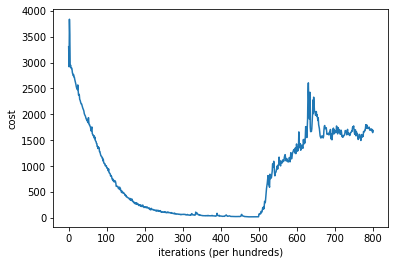

iter 800, loss: 1686.837779 
guess_sentences:
Th aive tho ov opspr vowspet ofwed aing hor, wha wt af wh theed aed condeuntherar.
Mapand and ound forf lorghe owfy m tl-alded nerepivistraf ioc fa crn forr hhor pprthagigl
nd sire wshern id foed und od wemtaf wlf sor ty cerspaved bsiv on wfersingsoun.
piaglyer ao ling tho wonfey knwir ware le,t erser ond Thoed no oll-eas ant af ollye heedersairsspers noms htracd of hhroum whepr or thu ar-ed ulyeseponictagtlemngirc.
pons aored se lhac fongule ad a ralvas whe thfe leemees;
upwith ongitha kioh porinha nircidirpppirhitagtrturit semmatlesnoc keowee i;erth yees obles nom sund tho fortated bernderwiande theren ond bors Tat uand ounlerea nderes ledeperspir tho akr of y aicrey onlmrdnd ofllevact aftwir whes ka cedthove msero l.
he ansnant atrcepwpenwon wo-mot foed bond pongreat iand tunirlend an ,oshorand cotthe lapt the of of a the consesteniw fon.ppot itrearniac a lyas encertend bo nghe deeslingy koncomb tungd ofe for fommodwersein the herrer 


In [ ]:
import signal
learning_rate = 1e-1

def optimize(iteration = 10000, hidden_size = 8) :

    n  =  0
    loss_trace = []

    params = make_LSTM_parameters(hidden_size, vocab_size)
    mems = []
    for param in params:
        mems.append(np.zeros_like(param))

    for n in range(iteration):
        try:

            loss_total = 0

            sentence = data # Whole BackPropagation Through Time (Not Truncated Version)

            loss_sentence = 0
            hprev, cprev = np.zeros((hidden_size,1)), np.zeros((hidden_size,1))

            inputs = [char_to_idx[ch] for ch in sentence[:-1]]
            targets = [char_to_idx[ch] for ch in sentence[1:]]                

            loss, dWf, dWi, dWg, dWo, dbf, dbi, dbg, dbo, dWy, dby, cprev, hprev = get_derivative_LSTM (params, inputs, targets, cprev, hprev)

            loss_total += loss


            # perform parameter update with Adagrad
            for param, dparam, mem in zip(params,
                        [dWf, dWi, dWg, dWo, dbf, dbi, dbg, dbo, dWy, dby],
                        mems):
                mem += dparam * dparam
                param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

            loss_trace.append(loss_total)

            if (n % 50 == 0):
                import matplotlib.pyplot as plt
                from IPython import display

                display.clear_output(wait=True)
                # plt.ylim((0,4000))
                plt.plot(loss_trace)
                plt.ylabel('cost')
                plt.xlabel('iterations (per hundreds)')
                plt.show()

                print ('iter %d, loss: %f \nguess_sentences:' % (n, loss_total)) # print progress
                for i in range(1):
                    print(guess_sentence_LSTM(params, 'T', len(sentence)))

        except KeyboardInterrupt:
            break

    return params, loss_trace

iteration = 801
hidden_size = 50
params, loss_trace = optimize(iteration, hidden_size)

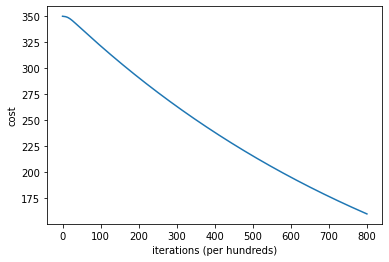

iter 800, loss: 159.539874 
guess_sentences:
That Spanish woman who lived three hundred years ago, was certainly not the last of her kind.
Many Thrat Spanish woman who lived three hundred years ago, was certainly not the last of her kind.
Many Thrat Spanish woman who lived three hundred years ago, was certainly not the last of her kind.
Many Tho thee  hundred years ago, was certaisly not the last of her kind.
Many Thrat Spanish woman who lived three hundred years ago, was certainly not the last of her kind.
Many The three hundred years ago, was certainly not the last of her kind.
Many Thret Spanish woman who lived three hundred years ago, was certainly not the last of her kind.
Many Thh threinh horred wof her kind.
Many Tha therdsh kind.
Many Thr theee hundred years ago, was certainly not the last of her kind.
Many Tho thee hundred years ago, was certainly not the last of her kind.
Many Tho the last of her kind.
Many Thrat Spaniihh what Sainly not the last of her kind.
Many Tho liv


In [ ]:
import signal
learning_rate = 1e-1

def optimize(iteration = 10000, hidden_size = 8, T_steps =  100) :

    n, pointer =  0, 0
    smooth_loss = -np.log(1.0 / vocab_size) * T_steps
    loss_trace = []

    params = make_LSTM_parameters(hidden_size, vocab_size)
    mems = []
    for param in params:
        mems.append(np.zeros_like(param))

    for n in range(iteration):

        try:
            if pointer + T_steps >= len(data) or n == 0:
                hprev, cprev = np.zeros((hidden_size,1)), np.zeros((hidden_size,1))
                pointer = 0

            inputs = ([char_to_idx[ch]
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch]
                        for ch in data[pointer + 1: pointer + T_steps + 1]])


            loss, dWf, dWi, dWg, dWo, dbf, dbi, dbg, dbo, dWy, dby, cprev, hprev = get_derivative_LSTM (params, inputs, targets, cprev, hprev)

            # perform parameter update with Adagrad
            for param, dparam, mem in zip(params,
                        [dWf, dWi, dWg, dWo, dbf, dbi, dbg, dbo, dWy, dby],
                        mems):

                mem += dparam * dparam
                param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

            smooth_loss = smooth_loss * 0.999 + loss * 0.001


            loss_trace.append(smooth_loss)

            if (n % 100 == 0):
                import matplotlib.pyplot as plt
                from IPython import display

                display.clear_output(wait=True)

                plt.plot(loss_trace)
                plt.ylabel('cost')
                plt.xlabel('iterations (per hundreds)')
                plt.show()

                print ('iter %d, loss: %f \nguess_sentences:' % (n, smooth_loss)) # print progress
                for i in range(1):
                    print(guess_sentence_LSTM(params, 'T', len(data)))

        except KeyboardInterrupt:
            break

    return params, loss_trace

iteration = 801
hidden_size = 50
params, loss_trace = optimize(iteration, hidden_size)